### Reimplementation of Image Super-Resolution Using Deep Convolutional Network in PyTorch

This notebook is the reimplementation of this [paper](https://arxiv.org/abs/1501.00092)

In [1]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import numpy as np
import time
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [3]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.input = self.file['data']
        self.target = self.file['label']
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self,idx):
        input = torch.tensor(self.input[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        
        return input, target
    
    def close(self):
        self.file.close()       

Image input size:  torch.Size([3, 33, 33])


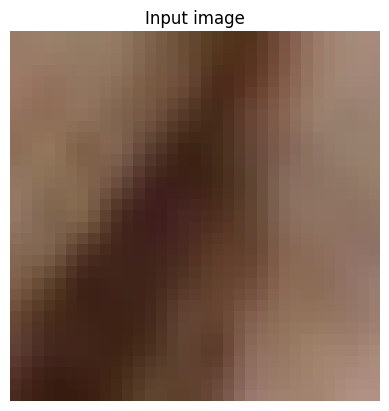

Image target size:  torch.Size([3, 21, 21])


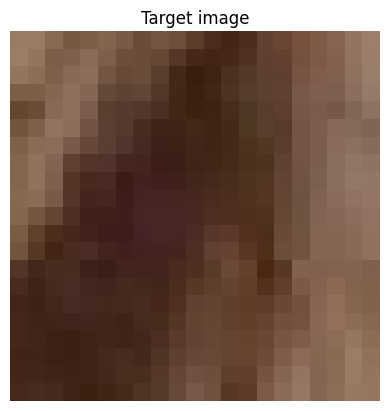

In [4]:
# Create an instance of MyDataset
dataset = MyDataset('train.h5')
test_dataset = MyDataset('test.h5')

# Choose the index of the data point you want to print
index_to_print = 4

# Retrieve the specified data point from the dataset
input, target = dataset[index_to_print]
image_test, label_test = test_dataset[index_to_print]


print("Image input size: ", input.size())


# Convert the image tensor to a PIL image for visualization
pil_input = to_pil_image(input)
pil_target = to_pil_image(target)

# Display the image using Matplotlib
plt.imshow(pil_input)
plt.title("Input image")
plt.axis('off')
plt.show()

print("Image target size: ", target.size())
# Print information about the label
plt.title("Target image")
plt.imshow(pil_target)
plt.axis('off')
plt.show()


# Close the dataset (important for releasing resources)
dataset.close()

### Preparing Datasets and Dataloaders

The train.h5 and test.h5 files are obtained by running the MATLAB scripts generate_train and generate_test respectively from [this](https://mmlab.ie.cuhk.edu.hk/projects/SRCNN/SRCNN_train.zip) source code given in the original paper

In [5]:
# Define dataset and dataloader
dataset = MyDataset('train.h5') 
train_loader = DataLoader(dataset, batch_size=128)

dataset_test_set5 = MyDataset('test.h5')
val_loader = DataLoader(dataset_test_set5, batch_size=128)

### Defining the CNN model

In [6]:
# Define the SRCNN model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Feature extraction layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),  # Input channels: 3 (RGB)
            nn.ReLU(True)
        )
        # Non-linear mapping layer
        self.map = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True)
        )
        # Reconstruction layer
        self.reconstruction = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        self.upsample = nn.Upsample(scale_factor=1.5715, mode='bicubic')  # Upsample to match target size (33x33)

        
    def forward(self, x):
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        out = self.upsample(out)
        return out
    
    def _initialize_weights(self):
        # Initialize weights with Gaussian distribution (std=0.001) and bias with zeros
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initialize convolutional layer weights with Gaussian distribution (std=0.001)
                nn.init.normal_(m.weight, mean=0, std=0.001)
                if m.bias is not None:
                    # Initialize bias with zeros
                    nn.init.constant_(m.bias, 0)

model = SRCNN()

In [31]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),  # Input channels: 3 (RGB)
            nn.ReLU(True)
        )
        self.map = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True)
        )
        self.reconstruction = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out[:, :, 6:-6, 6:-6]  # Crop the output to match the size 21x21

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.001)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Initialize model, loss function, and optimizer
model = SRCNN()
criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
num_epochs = 50

### Training loop

In [33]:
import torch.nn.functional as F

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss after each epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

end_time = time.time()
training_time_baseline = end_time - start_time
print(f"Training completed in {training_time_baseline:.2f} seconds")

# Save the trained model
torch.save(model.state_dict(), 'srcnn_model.pth')

Epoch 1, Loss: 0.011349091517245944
Epoch 2, Loss: 0.005335037136340842
Epoch 3, Loss: 0.0040709224310429655
Epoch 4, Loss: 0.0032923476989654933
Epoch 5, Loss: 0.0029209393021814964
Epoch 6, Loss: 0.002727379692334901
Epoch 7, Loss: 0.0025875384494771854
Epoch 8, Loss: 0.00247350808863035
Epoch 9, Loss: 0.0023779298233635284
Epoch 10, Loss: 0.002297022959957009
Epoch 11, Loss: 0.0022281550562611835
Epoch 12, Loss: 0.0021692450925269546
Epoch 13, Loss: 0.0021185523248277603
Epoch 14, Loss: 0.002074951894225224
Epoch 15, Loss: 0.0020374974619378062
Epoch 16, Loss: 0.002005101549986969
Epoch 17, Loss: 0.001976787397528396
Epoch 18, Loss: 0.0019517567152540912
Epoch 19, Loss: 0.0019293784513138234
Epoch 20, Loss: 0.0019091484568300931
Epoch 21, Loss: 0.0018906679798794143
Epoch 22, Loss: 0.0018736225484377322
Epoch 23, Loss: 0.0018577649504603708
Epoch 24, Loss: 0.0018428995109656277
Epoch 25, Loss: 0.0018288732848732788
Epoch 26, Loss: 0.0018155645325725132
Epoch 27, Loss: 0.001802878626

### Test validation loss using validation loader

In [34]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

to_pil_image = ToPILImage()

# Evaluate model on validation dataset
model.eval()
val_loss = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(val_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        # Ensure the output and target sizes match
        if val_outputs.size() != val_labels.size():
            val_outputs = F.interpolate(val_outputs, size=val_labels.size()[2:], mode='bicubic', align_corners=False)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {average_val_loss}")

Validation Loss: 0.0008790928477537818


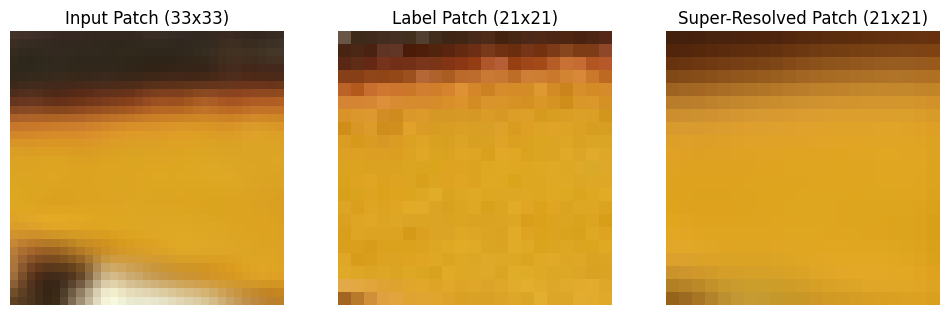

In [35]:
# Function to modcrop the image
def modcrop(img, scale):
    h, w = img.shape[1], img.shape[2]
    h = h - (h % scale)
    w = w - (w % scale)
    img = img[:, :h, :w]
    return img

# Load the input image
input_image_path = 'butterfly_GT.bmp'
input_image = Image.open(input_image_path).convert('RGB')

# Convert the image to tensor
input_image = TF.to_tensor(input_image).float()  # Change to float

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
scale = 3
stride = 14

# Process image for label and input
im_label = modcrop(input_image, scale)
im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

# Extract patches from the input image
data = []
label = []
padding = (input_patch_size - output_patch_size) // 2

for y in range(0, im_label.shape[1] - input_patch_size + 1, stride):
    for x in range(0, im_label.shape[2] - input_patch_size + 1, stride):
        # Extract input and label patches
        subim_input = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
        subim_label = im_label[:, y + padding:y + padding + output_patch_size, x + padding:x + padding + output_patch_size]

        data.append(subim_input)
        label.append(subim_label)

# Convert lists of tensors to batch tensors
data = torch.stack(data).float()  # Change to float
label = torch.stack(label).float()  # Change to float

model = SRCNN()
model.load_state_dict(torch.load('srcnn_model.pth'))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(data)

# Visualize a specific output patch
patch_index = 23  # Example patch index to visualize

# Convert tensors to PIL images
input_patch_tensor = data[patch_index].detach().cpu()
label_patch_tensor = label[patch_index].detach().cpu()
output_patch_tensor = output_batch[patch_index].detach().cpu()

input_patch_pil = TF.to_pil_image(input_patch_tensor)
label_patch_pil = TF.to_pil_image(label_patch_tensor)
output_patch_pil = TF.to_pil_image(output_patch_tensor)

# Display the input patch, label patch (ground truth), and the model's output (super-resolved patch)
plt.figure(figsize=(12, 4))

# Display input patch
plt.subplot(1, 3, 1)
plt.imshow(input_patch_pil)
plt.title('Input Patch (33x33)')
plt.axis('off')

# Display label patch (ground truth)
plt.subplot(1, 3, 2)
plt.imshow(label_patch_pil)
plt.title('Label Patch (21x21)')
plt.axis('off')

# Display output patch (super-resolved)
plt.subplot(1, 3, 3)
plt.imshow(output_patch_pil)
plt.title('Super-Resolved Patch (21x21)')
plt.axis('off')

plt.show()


### Testing the images and store results in /results directory

In [36]:
import os
from PIL import Image
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Function to modcrop the image
def modcrop(img, scale):
    h, w = img.shape[1], img.shape[2]
    h = h - (h % scale)
    w = w - (w % scale)
    img = img[:, :h, :w]
    return img

# Load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Directories containing the images
directories = ["data/Test/Set5", "data/Test/Set14"]

# Process each image in the directories
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(".bmp"):
            input_image_path = os.path.join(directory, filename)

            # Load the input image
            input_image = Image.open(input_image_path).convert("RGB")

            # Convert the image to tensor
            input_image = TF.to_tensor(input_image).float()

            # Define patch size and stride
            input_patch_size = 33
            output_patch_size = 21
            scale = 3
            stride = 14

            # Process image for label and input
            im_label = modcrop(input_image, scale)
            im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
            im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

            # Extract patches from the input image
            patches = []
            coords = []
            image_width, image_height = im_input.shape[2], im_input.shape[1]

            for y in range(0, image_height - input_patch_size + 1, stride):
                for x in range(0, image_width - input_patch_size + 1, stride):
                    # Crop input patch from the image
                    input_patch = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
                    patches.append(input_patch)
                    coords.append((x, y))

            # Handle the right and bottom edges
            for y in range(0, image_height - input_patch_size + 1, stride):
                input_patch = im_input[:, y:y + input_patch_size, image_width - input_patch_size:image_width]
                patches.append(input_patch)
                coords.append((image_width - input_patch_size, y))

            for x in range(0, image_width - input_patch_size + 1, stride):
                input_patch = im_input[:, image_height - input_patch_size:image_height, x:x + input_patch_size]
                patches.append(input_patch)
                coords.append((x, image_height - input_patch_size))

            input_patch = im_input[:, image_height - input_patch_size:image_height, image_width - input_patch_size:image_width]
            patches.append(input_patch)
            coords.append((image_width - input_patch_size, image_height - input_patch_size))

            # Convert list of tensors to a batch tensor
            input_batch = torch.stack(patches).float()

            # Perform inference on the input patches using the model
            with torch.no_grad():
                output_batch = model(input_batch)

            # Initialize an empty tensor for the output image
            output_image = torch.zeros(3, image_height, image_width)

            # Initialize an empty tensor to count overlapping regions
            overlap_count = torch.zeros(image_height, image_width)

            # Place each output patch back into the correct location in the output image
            for i, (x, y) in enumerate(coords):
                output_patch = output_batch[i]
                output_image[:, y:y + output_patch_size, x:x + output_patch_size] += output_patch
                overlap_count[y:y + output_patch_size, x:x + output_patch_size] += 1

            # Average overlapping regions
            output_image /= overlap_count

            # Convert the output image tensor to a PIL image
            output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))

            # Save the output image
            result_image_name = os.path.basename(filename).replace("_GT.bmp", "_SR.bmp")
            output_image_pil.save(os.path.join("results", result_image_name))

            print(f"Processed {filename} and saved result as {result_image_name}")


Processed baby_GT.bmp and saved result as baby_SR.bmp
Processed bird_GT.bmp and saved result as bird_SR.bmp
Processed butterfly_GT.bmp and saved result as butterfly_SR.bmp
Processed head_GT.bmp and saved result as head_SR.bmp
Processed woman_GT.bmp and saved result as woman_SR.bmp
Processed baboon.bmp and saved result as baboon.bmp
Processed barbara.bmp and saved result as barbara.bmp
Processed bridge.bmp and saved result as bridge.bmp
Processed coastguard.bmp and saved result as coastguard.bmp
Processed comic.bmp and saved result as comic.bmp
Processed face.bmp and saved result as face.bmp
Processed flowers.bmp and saved result as flowers.bmp
Processed foreman.bmp and saved result as foreman.bmp
Processed lenna.bmp and saved result as lenna.bmp
Processed man.bmp and saved result as man.bmp
Processed monarch.bmp and saved result as monarch.bmp
Processed pepper.bmp and saved result as pepper.bmp
Processed ppt3.bmp and saved result as ppt3.bmp
Processed zebra.bmp and saved result as zebr

### View an image results for comparison

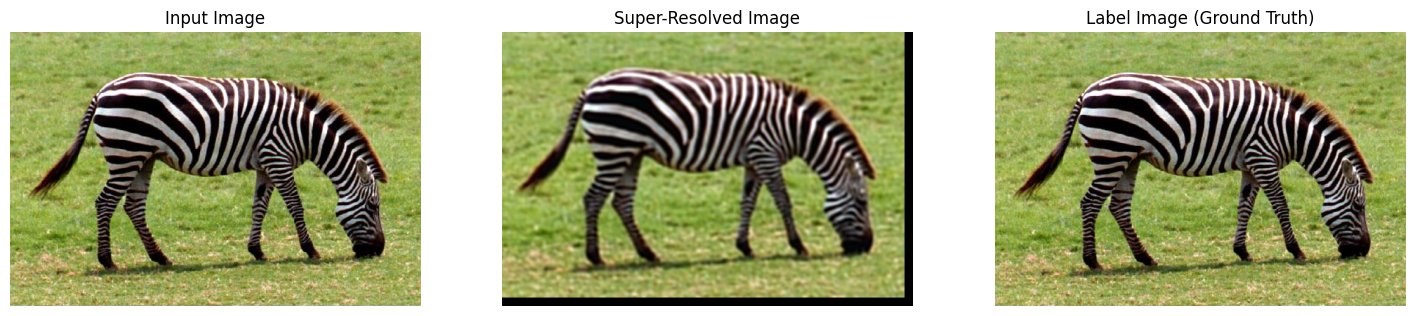

In [37]:
# Load the input image
input_image_path = "zebra.bmp"
input_image = Image.open(input_image_path).convert("RGB")

# Convert the image to tensor
input_image = TF.to_tensor(input_image).float()

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
scale = 3
stride = 14

# Process image for label and input
im_label = modcrop(input_image, scale)
im_input = TF.resize(im_label, [im_label.shape[1] // scale, im_label.shape[2] // scale], interpolation=TF.InterpolationMode.BICUBIC)
im_input = TF.resize(im_input, [im_label.shape[1], im_label.shape[2]], interpolation=TF.InterpolationMode.BICUBIC)

# Extract patches from the input image
patches = []
coords = []
image_width, image_height = im_input.shape[2], im_input.shape[1]

for y in range(0, image_height - input_patch_size + 1, stride):
    for x in range(0, image_width - input_patch_size + 1, stride):
        # Crop input patch from the image
        input_patch = im_input[:, y:y + input_patch_size, x:x + input_patch_size]
        patches.append(input_patch)
        coords.append((x, y))

# Handle the right and bottom edges
for y in range(0, image_height - input_patch_size + 1, stride):
    input_patch = im_input[:, y:y + input_patch_size, image_width - input_patch_size:image_width]
    patches.append(input_patch)
    coords.append((image_width - input_patch_size, y))

for x in range(0, image_width - input_patch_size + 1, stride):
    input_patch = im_input[:, image_height - input_patch_size:image_height, x:x + input_patch_size]
    patches.append(input_patch)
    coords.append((x, image_height - input_patch_size))

input_patch = im_input[:, image_height - input_patch_size:image_height, image_width - input_patch_size:image_width]
patches.append(input_patch)
coords.append((image_width - input_patch_size, image_height - input_patch_size))

# Convert list of tensors to a batch tensor
input_batch = torch.stack(patches).float()

# Load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load("srcnn_model.pth"))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(input_batch)

# Initialize an empty tensor for the output image
output_image = torch.zeros(3, image_height, image_width)

# Initialize an empty tensor to count overlapping regions
overlap_count = torch.zeros(image_height, image_width)

# Place each output patch back into the correct location in the output image
for i, (x, y) in enumerate(coords):
    output_patch = output_batch[i]
    output_image[:, y:y + output_patch_size, x:x + output_patch_size] += output_patch
    overlap_count[y:y + output_patch_size, x:x + output_patch_size] += 1

# Average overlapping regions
output_image /= overlap_count

# Convert the output image tensor to a PIL image
output_image_pil = TF.to_pil_image(output_image.clamp(0, 1))

# Display the input image, label image, and the super-resolved image
plt.figure(figsize=(18, 6))

# Display input image
plt.subplot(1, 3, 1)
input_image_pil = TF.to_pil_image(input_image)
plt.imshow(input_image_pil)
plt.title("Input Image")
plt.axis("off")

# Display super-resolved image
plt.subplot(1, 3, 2)
plt.imshow(output_image_pil)
plt.title("Super-Resolved Image")
plt.axis("off")

# Display label image
plt.subplot(1, 3, 3)
label_image_pil = TF.to_pil_image(im_label)
plt.imshow(label_image_pil)
plt.title("Label Image (Ground Truth)")
plt.axis("off")

plt.show()
